This is serves as my final project for CS 5483. This project aims to ask 2 main questions:
a. Under a simulation of disruption, what would happen to the network if major hubs/airports were to stop working? Is the network resilient?
b. Are there optmila routes to be discovered through the use of underutilized airports?

First, we start by importing all the libraries necessary

In [33]:
import pandas as pd
import networkx as nx
from networkx.algorithms.centrality import edge_betweenness_centrality
import matplotlib.pyplot as plt
from networkx.algorithms.community.quality import modularity
import community as community_louvain


In [34]:
file_path = "US-Airline-Flight-Routes-and-Fares-1993-2024.csv"

df = pd.read_csv(file_path)

/var/folders/9q/gbjddknj7mq1767dkmfmh8600000gn/T/ipykernel_12199/4121340720.py:3: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


After reading the csv file, I will filter the data to just have the departure airport, arrival airport and the miles between. I will be using these to iteratively add the edges onto the graph.

In [35]:
df_filtered = df[(df['Year'] == 2023) | (df['Year'] == 2024)]
df_filtered = df_filtered[['airport_1', 'airport_2', 'nsmiles']]

In [36]:
# Create an undirected graph
G = nx.Graph()

# Add edges with weights (distance in miles)
for _, row in df_filtered.iterrows():
    airport_1 = row['airport_1']
    airport_2 = row['airport_2']
    distance = row['nsmiles']
    
    # Check for missing or invalid data
    if pd.notna(airport_1) and pd.notna(airport_2) and pd.notna(distance):
        G.add_edge(airport_1, airport_2, weight=distance)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 148
Number of edges: 2176


This is where I calculate average shortest path of the network and the dimater of the network, which are important statistics to have for later on.

In [37]:
avg_shortest_path = nx.average_shortest_path_length(G, weight='weight')
print(f"Average shortest path length: {avg_shortest_path}")

diameter = nx.diameter(G, weight='weight')
print(f"Diameter of the graph: {diameter}")


Average shortest path length: 1782.7862658576944
Diameter of the graph: 5546


Using degree centrality function, I find the top 10m most connected airports, or my hubs, and draw the graph, with red representing the hubs.

MDW 0.633
IND 0.204
AUS 0.190
PHX 0.592
ABE 0.014
PIE 0.163
TPA 0.517
ABQ 0.177
DAL 0.599
DFW 0.619
BWI 0.599
DCA 0.605
IAD 0.592
ORD 0.646
HOU 0.551
IAH 0.537
EWR 0.646
HPN 0.646
ISP 0.510
JFK 0.653
LGA 0.660
OAK 0.483
SFO 0.483
SJC 0.483
BUR 0.592
LAX 0.599
LGB 0.544
ONT 0.599
SNA 0.605
ACY 0.020
FLL 0.544
MIA 0.531
COS 0.102
PIT 0.204
DEN 0.245
TUS 0.150
BDL 0.129
SEA 0.231
ELP 0.156
BNA 0.218
STL 0.211
JAX 0.204
DTW 0.197
DSM 0.170
MCO 0.231
ECP 0.014
VPS 0.034
MSP 0.231
RSW 0.197
GSP 0.082
GRR 0.177
HRL 0.027
LAS 0.252
LIT 0.082
LBB 0.027
SDF 0.184
MAF 0.027
SMF 0.170
MCI 0.204
SAT 0.197
MEM 0.184
OMA 0.190
MKE 0.184
MSY 0.204
SAN 0.204
ORF 0.204
PHF 0.163
PNS 0.095
PBI 0.156
PDX 0.204
PHL 0.163
PSP 0.082
RDU 0.197
RIC 0.184
RNO 0.156
SLC 0.197
TUL 0.122
SAV 0.163
HSV 0.020
ALB 0.095
AMA 0.014
SWF 0.116
ASE 0.054
ATL 0.238
CAK 0.265
CLE 0.299
BOS 0.490
MHT 0.483
PVD 0.476
CMH 0.272
ATW 0.014
AZA 0.163
AVL 0.088
FSD 0.014
GEG 0.068
PVU 0.027
BHM 0.136
BIL 0.014
BIS 0.014
SRQ 0.116


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


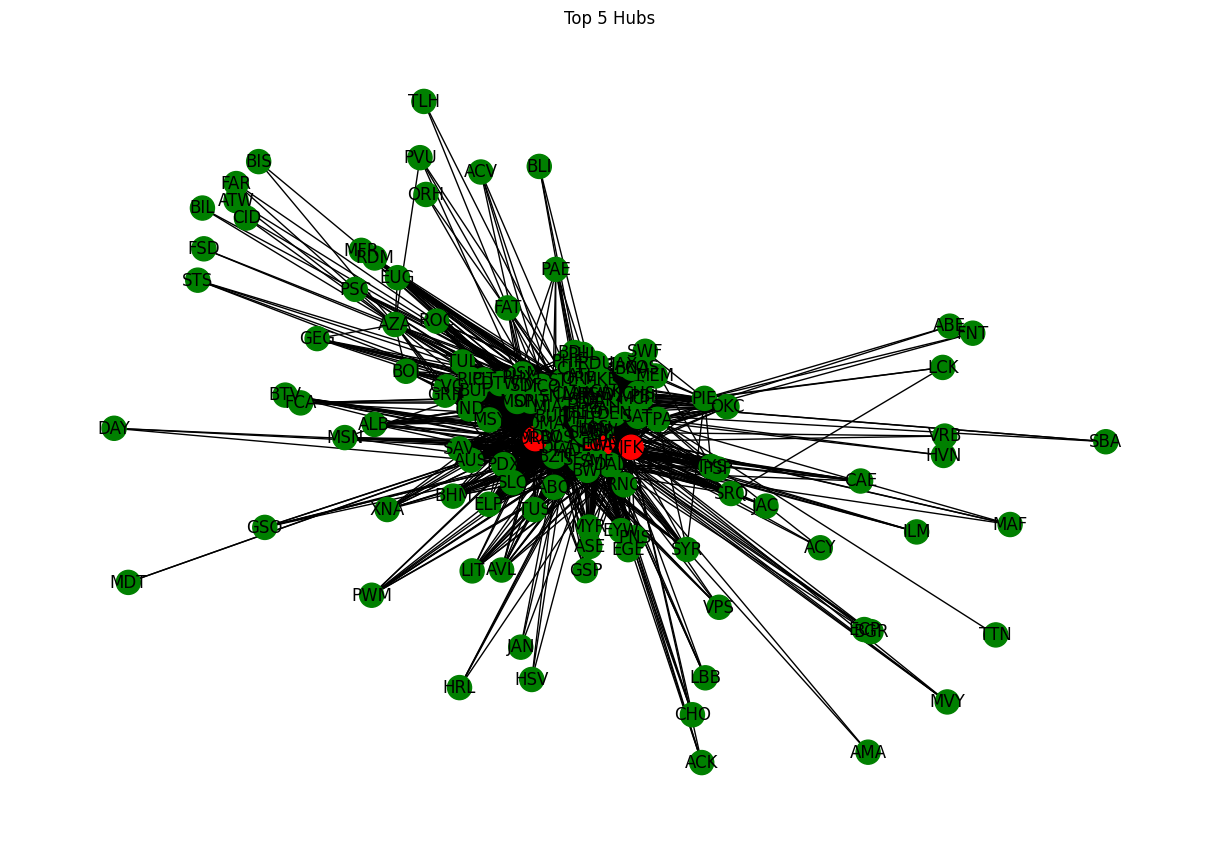

In [38]:
d = nx.degree_centrality(G)
for v in G.nodes():
    print(f"{v:2} {d[v]:.3f}")
sort_list = sorted(d.items(), key=lambda x: x[1], reverse=True)

top_hubs = [sort_list[0][0], sort_list[1][0], sort_list[2][0], sort_list[3][0], sort_list[4][0]]  # Top 5 hubs
print(f"Top hubs: {top_hubs}")

color_map = []
for node in G:
    if (node == sort_list[0][0]) or (node== sort_list[1][0]) or (node== sort_list[2][0]) or (node== sort_list[3][0]) or (node== sort_list[4][0]):
        color_map.append('red')
    else: 
        color_map.append('green')      
#nx.draw(G, node_color=color_map, with_labels=True)
plt.figure(figsize=(12, 8))
nx.draw(G, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("Top 5 Hubs")
plt.show()


Here is where I simulate the disruptions by removing all 5 of them iteratively and calculate the statistics of the network with each removal to test the resilience with each removal. I then illustrate the result after the removal of all hubs.

In [39]:
G_disrupted_calc = G.copy()

for hub in top_hubs:
    # Remove the hub
    G_disrupted_calc.remove_node(hub)
    print(f"\nRemoved hub: {hub}")
    
    # Analyze connectivity
    connected_components = list(nx.connected_components(G_disrupted_calc))
    print(f"Number of connected components after removing {hub}: {len(connected_components)}")

    # Count the number of disconnected nodes (single-node components)
    disconnected_nodes = [comp for comp in connected_components if len(comp) == 1]
    print(f"Number of disconnected nodes after removing {hub}: {len(disconnected_nodes)}")
    
    # Calculate shortest paths between all pairs
    shortest_paths = {}
    for source in G_disrupted_calc.nodes():
        for target in G_disrupted_calc.nodes():
            if source != target:
                try:
                    # Compute shortest path length
                    path_length = nx.shortest_path_length(G_disrupted_calc, source=source, target=target, weight='weight')
                    shortest_paths[(source, target)] = path_length
                except nx.NetworkXNoPath:
                    shortest_paths[(source, target)] = None  # No path exists

    # Calculate average shortest path length (only for connected pairs)
    connected_paths = [length for length in shortest_paths.values() if length is not None]
    if connected_paths:
        avg_shortest_path = sum(connected_paths) / len(connected_paths)
        print(f"Average shortest path length after removing {hub}: {avg_shortest_path:.2f}")
    else:
        print(f"All nodes are disconnected after removing {hub}.")

print(connected_components)


Removed hub: LGA
Number of connected components after removing LGA: 1
Number of disconnected nodes after removing LGA: 0
Average shortest path length after removing LGA: 1787.30

Removed hub: JFK
Number of connected components after removing JFK: 1
Number of disconnected nodes after removing JFK: 0
Average shortest path length after removing JFK: 1791.80

Removed hub: ORD
Number of connected components after removing ORD: 1
Number of disconnected nodes after removing ORD: 0
Average shortest path length after removing ORD: 1800.65

Removed hub: EWR
Number of connected components after removing EWR: 1
Number of disconnected nodes after removing EWR: 0
Average shortest path length after removing EWR: 1806.54

Removed hub: HPN
Number of connected components after removing HPN: 7
Number of disconnected nodes after removing HPN: 6
Average shortest path length after removing HPN: 1799.00
[{'OMA', 'TUS', 'MHT', 'SEA', 'MCO', 'SAV', 'MFR', 'ORH', 'BUF', 'SBA', 'BWI', 'SWF', 'BIS', 'PHX', 'TYS'

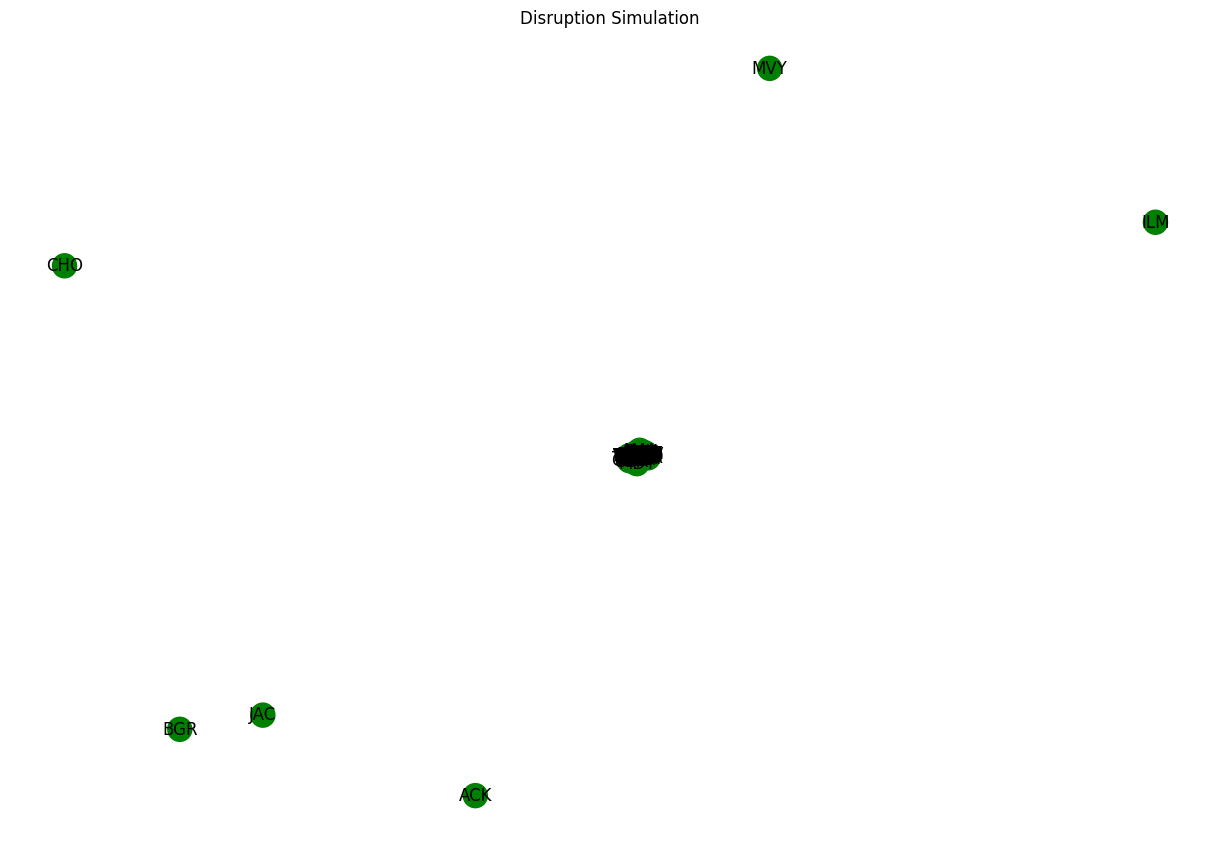

In [40]:
color_map = []
for node in G_disrupted_calc:
    if node in top_hubs:
        color_map.append('red')  # Mark removed hubs in red
    else:
        color_map.append('green')  # Mark remaining nodes in green

#nx.draw(G_disrupted, node_color=color_map, with_labels=True)
plt.figure(figsize=(12, 8))
nx.draw(G_disrupted_calc, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("Disruption Simulation")
plt.show()

This is where I define functions for the Girvan Newman calculation.

In [41]:
def edge_to_remove(g):
    betwen_cen = nx.edge_betweenness_centrality(g)
    list_of_tuples = list(betwen_cen.items())
    
    # Sort edges by betweenness centrality (highest first)
    list_of_tuples.sort(key=lambda x: x[1], reverse=True)
    
    # Return the edge with the highest betweenness
    return list_of_tuples[0][0]

def girvan_newman(g, num_communities):
    # Initial number of components
    components = list(nx.connected_components(g))
    while len(components) < num_communities:
        # Remove the edge with the highest betweenness centrality
        u, v = edge_to_remove(g)
        g.remove_edge(u, v)
        
        # Update components
        components = list(nx.connected_components(g))
        print(f"Number of connected components: {len(components)}")
    
    return components

I test out by limiting the communities to 3 at first and drawing the graph.

Number of connected components: 2
Number of connected components: 2
Number of connected components: 3
Community 1: {'OMA', 'TUS', 'MHT', 'SEA', 'MCO', 'SAV', 'MFR', 'ORH', 'EWR', 'BUF', 'SBA', 'BWI', 'SWF', 'BIS', 'PHX', 'TYS', 'AZA', 'SNA', 'ASE', 'PSC', 'EGE', 'BGR', 'DFW', 'BZN', 'ACV', 'SRQ', 'BNA', 'HOU', 'RSW', 'RNO', 'OAK', 'ACK', 'JAX', 'SJC', 'GRR', 'BUR', 'JAN', 'BDL', 'IAD', 'CMH', 'AUS', 'PHF', 'FNT', 'LIT', 'ATL', 'FAT', 'BIL', 'ILM', 'ONT', 'CVG', 'MSP', 'PHL', 'BTV', 'PBI', 'MSN', 'MDW', 'DAY', 'MEM', 'BOS', 'LGA', 'LAX', 'TPA', 'SYR', 'JFK', 'PWM', 'DCA', 'FLL', 'MVY', 'FAR', 'ACY', 'COS', 'FCA', 'GSP', 'SMF', 'CLT', 'HSV', 'CHS', 'FSD', 'OKC', 'ATW', 'ORF', 'PDX', 'ABQ', 'SAT', 'SFO', 'BOI', 'LGB', 'TUL', 'XNA', 'PAE', 'GEG', 'LAS', 'MAF', 'ALB', 'PSP', 'GSO', 'RDU', 'ORD', 'ISP', 'DTW', 'IND', 'CAK', 'DAL', 'RDM', 'AVL', 'CHO', 'MIA', 'DEN', 'MYR', 'VRB', 'STS', 'SAN', 'TLH', 'ECP', 'BHM', 'RIC', 'MSY', 'EYW', 'PVD', 'SLC', 'IAH', 'HRL', 'MCI', 'AMA', 'EUG', 'CID', 'H

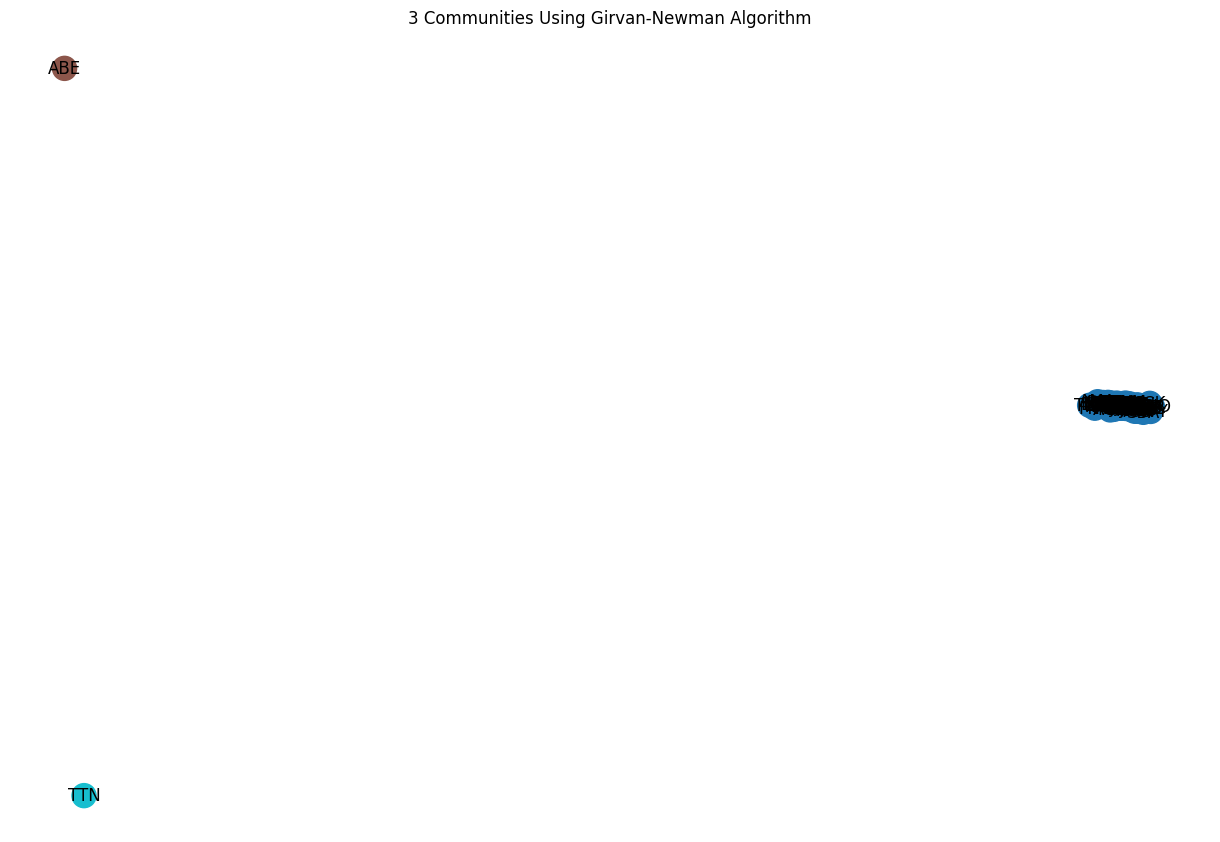

In [42]:
num_communities = 3
G_copy = G.copy()
communities = girvan_newman(G_copy, num_communities)

for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {community}")

color_map = []
for node in G_copy:
    for i, community in enumerate(communities):
        if node in community:
            color_map.append(i)

plt.figure(figsize=(12, 8))
nx.draw(G_copy, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("3 Communities Using Girvan-Newman Algorithm")
plt.show()

I then test with 4 communities, and eventually 5.

Number of connected components: 2
Number of connected components: 2
Number of connected components: 3
Number of connected components: 3
Number of connected components: 4
Community 1: {'OMA', 'TUS', 'MHT', 'SEA', 'MCO', 'SAV', 'MFR', 'ORH', 'EWR', 'BUF', 'SBA', 'BWI', 'SWF', 'BIS', 'PHX', 'TYS', 'AZA', 'SNA', 'ASE', 'PSC', 'EGE', 'BGR', 'DFW', 'BZN', 'ACV', 'SRQ', 'BNA', 'HOU', 'RSW', 'RNO', 'OAK', 'ACK', 'JAX', 'SJC', 'GRR', 'BUR', 'JAN', 'BDL', 'IAD', 'CMH', 'AUS', 'PHF', 'LIT', 'ATL', 'FAT', 'BIL', 'ILM', 'ONT', 'CVG', 'MSP', 'PHL', 'BTV', 'PBI', 'MSN', 'MDW', 'DAY', 'MEM', 'BOS', 'LGA', 'LAX', 'TPA', 'SYR', 'JFK', 'PWM', 'DCA', 'FLL', 'MVY', 'FAR', 'ACY', 'COS', 'FCA', 'GSP', 'SMF', 'CLT', 'HSV', 'CHS', 'FSD', 'OKC', 'ATW', 'ORF', 'PDX', 'ABQ', 'SAT', 'SFO', 'BOI', 'LGB', 'TUL', 'XNA', 'PAE', 'GEG', 'LAS', 'MAF', 'ALB', 'PSP', 'GSO', 'RDU', 'ORD', 'ISP', 'DTW', 'IND', 'CAK', 'DAL', 'RDM', 'AVL', 'CHO', 'MIA', 'DEN', 'MYR', 'VRB', 'STS', 'SAN', 'TLH', 'ECP', 'BHM', 'RIC', 'MSY', 'EYW

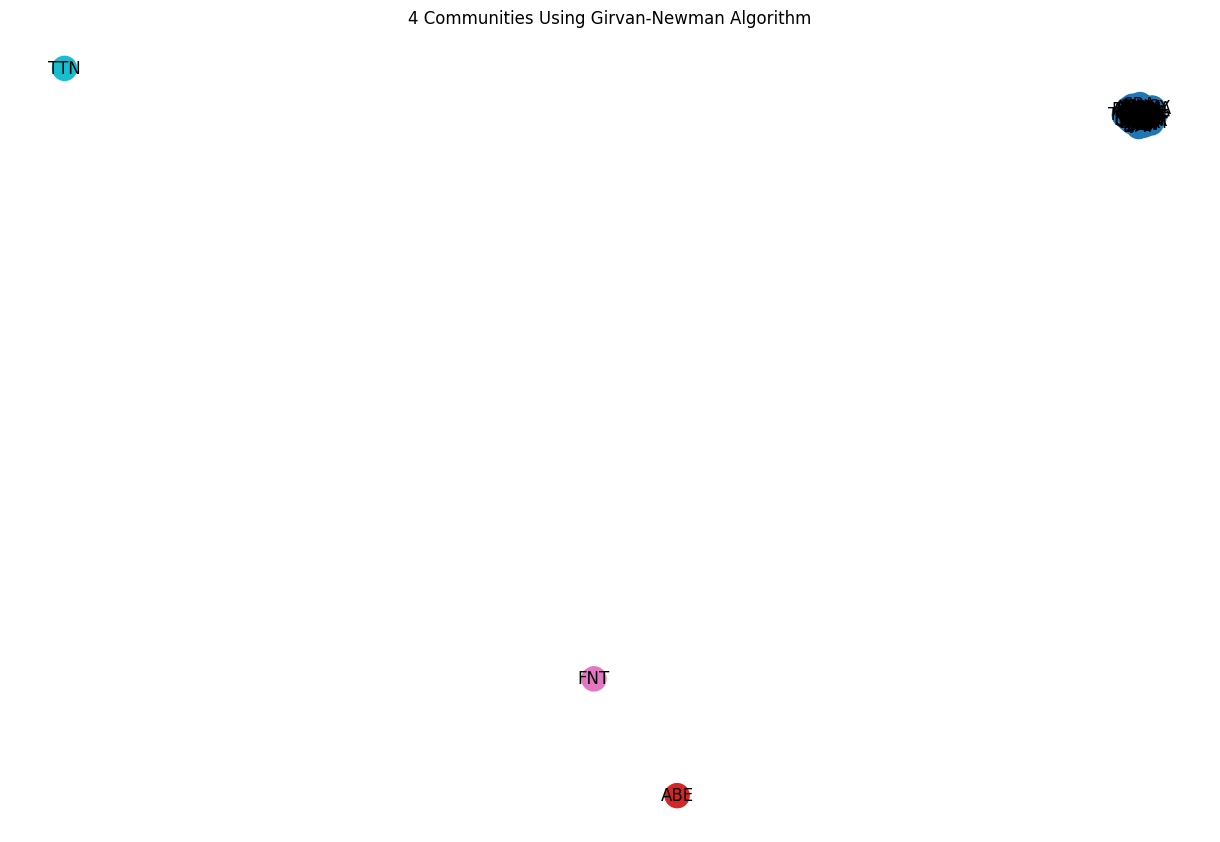

In [43]:
G_4_comm = G.copy()
num_communities = 4
communities = girvan_newman(G_4_comm, num_communities)

for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {community}")

color_map = []
for node in G_4_comm:
    for i, community in enumerate(communities):
        if node in community:
            color_map.append(i)

plt.figure(figsize=(12, 8))
nx.draw(G_4_comm, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("4 Communities Using Girvan-Newman Algorithm")
plt.show()

Number of connected components: 2
Number of connected components: 2
Number of connected components: 3
Number of connected components: 3
Number of connected components: 4
Number of connected components: 4
Number of connected components: 5
Community 1: {'OMA', 'TUS', 'MHT', 'SEA', 'MCO', 'SAV', 'MFR', 'ORH', 'EWR', 'BUF', 'SBA', 'BWI', 'SWF', 'BIS', 'PHX', 'TYS', 'AZA', 'SNA', 'ASE', 'PSC', 'EGE', 'BGR', 'DFW', 'BZN', 'ACV', 'SRQ', 'BNA', 'HOU', 'RSW', 'RNO', 'OAK', 'ACK', 'JAX', 'SJC', 'GRR', 'BUR', 'JAN', 'BDL', 'IAD', 'CMH', 'AUS', 'PHF', 'LIT', 'ATL', 'FAT', 'BIL', 'ILM', 'ONT', 'CVG', 'MSP', 'PHL', 'BTV', 'PBI', 'MSN', 'MDW', 'DAY', 'MEM', 'BOS', 'LGA', 'LAX', 'TPA', 'SYR', 'JFK', 'PWM', 'DCA', 'FLL', 'MVY', 'FAR', 'ACY', 'COS', 'FCA', 'GSP', 'SMF', 'CLT', 'HSV', 'CHS', 'FSD', 'OKC', 'ORF', 'PDX', 'ABQ', 'SAT', 'SFO', 'BOI', 'LGB', 'TUL', 'XNA', 'PAE', 'GEG', 'LAS', 'MAF', 'ALB', 'PSP', 'GSO', 'RDU', 'ORD', 'ISP', 'DTW', 'IND', 'CAK', 'DAL', 'RDM', 'AVL', 'CHO', 'MIA', 'DEN', 'MYR',

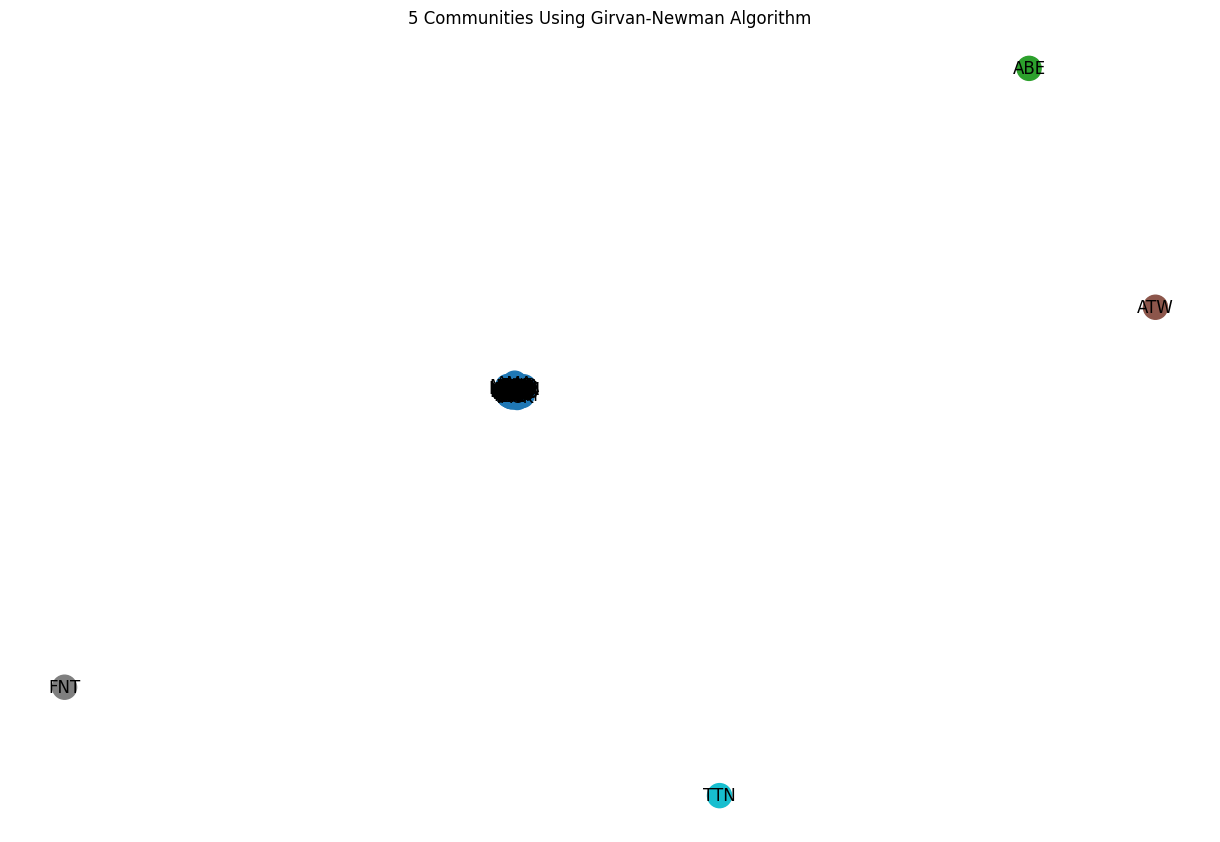

In [44]:
G_5_comm = G.copy()
num_communities = 5
communities = girvan_newman(G_5_comm, num_communities)

for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {community}")

color_map = []
for node in G_5_comm:
    for i, community in enumerate(communities):
        if node in community:
            color_map.append(i)

plt.figure(figsize=(12, 8))
nx.draw(G_5_comm, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("5 Communities Using Girvan-Newman Algorithm")
plt.show()

This is where I employ the Louvain Method instead of Girvan Method. I also print out stats for each of the partitions created.

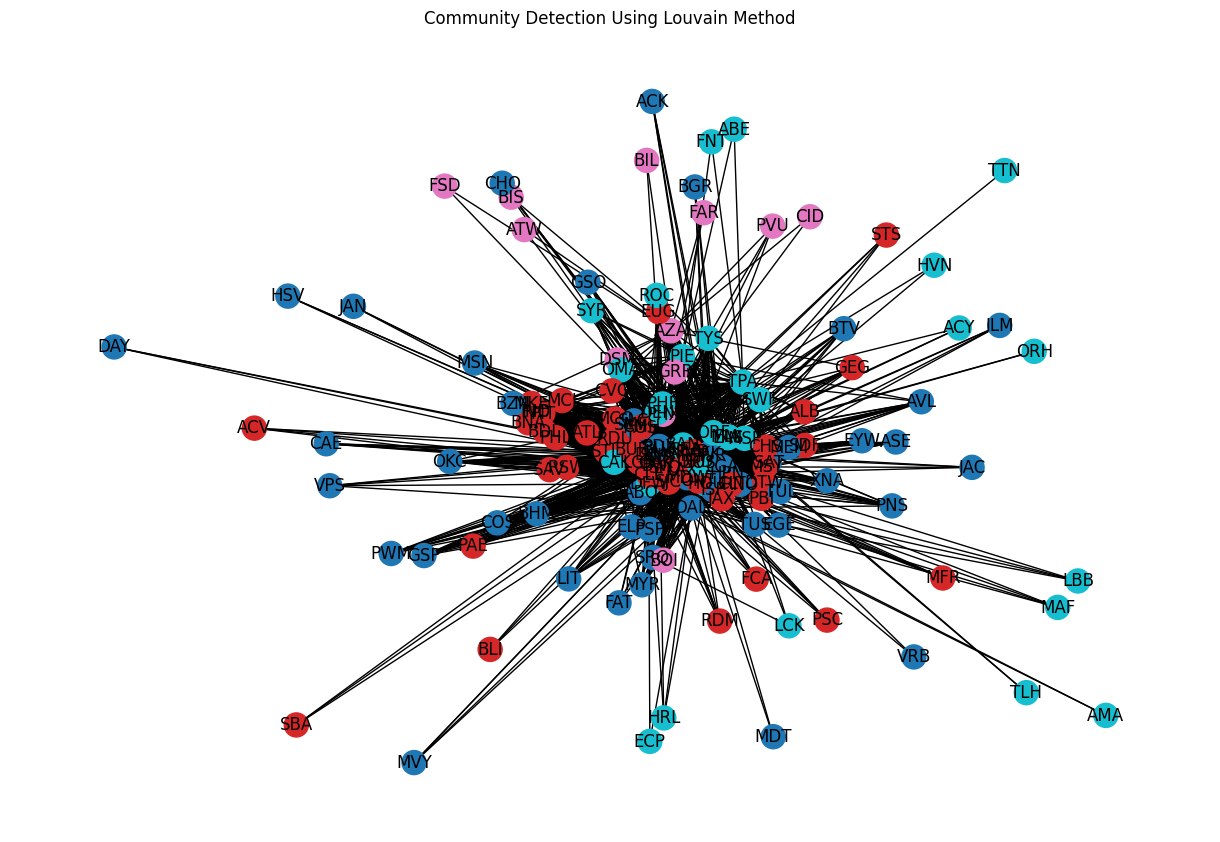

Number of communities detected: 4
Community 0: ['MDW', 'AUS', 'ABQ', 'DAL', 'BWI', 'DCA', 'IAD', 'ORD', 'EWR', 'HPN', 'ISP', 'JFK', 'LGA', 'COS', 'TUS', 'ELP', 'VPS', 'GSP', 'LIT', 'SMF', 'SAT', 'MEM', 'PNS', 'PDX', 'PSP', 'RNO', 'SLC', 'TUL', 'HSV', 'ASE', 'AVL', 'BHM', 'SRQ', 'BZN', 'MYR', 'EYW', 'BTV', 'CAE', 'OKC', 'DAY', 'EGE', 'FAT', 'ILM', 'PWM', 'XNA', 'GSO', 'JAC', 'JAN', 'MSN', 'ACK', 'MVY', 'BGR', 'MDT', 'CHO', 'VRB']
Community 1: ['IND', 'IAH', 'OAK', 'SFO', 'SJC', 'BUR', 'LAX', 'LGB', 'ONT', 'SNA', 'PIT', 'BDL', 'BNA', 'STL', 'JAX', 'DTW', 'MCO', 'RSW', 'SDF', 'MCI', 'MKE', 'MSY', 'PBI', 'PHL', 'RDU', 'RIC', 'SAV', 'ALB', 'ATL', 'CLE', 'MHT', 'PVD', 'CMH', 'GEG', 'BUF', 'CHS', 'CLT', 'CVG', 'EUG', 'SBA', 'MFR', 'STS', 'PAE', 'RDM', 'BLI', 'FCA', 'PSC', 'ACV']
Community 2: ['PHX', 'DSM', 'GRR', 'ATW', 'AZA', 'FSD', 'PVU', 'BIL', 'BIS', 'BOI', 'CID', 'FAR']
Community 3: ['ABE', 'PIE', 'TPA', 'DFW', 'HOU', 'ACY', 'FLL', 'MIA', 'DEN', 'SEA', 'ECP', 'MSP', 'HRL', 'LAS', 'LBB', 

In [45]:
G_copy = G.copy()

partition = community_louvain.best_partition(G_copy) 

color_map = []
for node in G_copy.nodes():
    color_map.append(partition[node])


plt.figure(figsize=(12, 8))
nx.draw(G_copy, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("Community Detection Using Louvain Method")
plt.show()

print(f"Number of communities detected: {len(set(partition.values()))}")

communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []  
    communities[community_id].append(node)

for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")

In [46]:
connected_components = list(nx.connected_components(G_copy))
print(f"Number of connected components after adding edges: {len(connected_components)}")

# Average shortest path length
try:
    avg_shortest_path = nx.average_shortest_path_length(G_copy, weight='weight')
    print(f"Average shortest path length after adding edges: {avg_shortest_path:.2f}")
except nx.NetworkXError:
    print("Graph is disconnected; average shortest path cannot be calculated.")

# Modularity
modularity_score = modularity(G_copy, [set(nodes) for nodes in communities.values()])
print(f"Modularity after adding edges: {modularity_score:.2f}")

partitions = {}

for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")
    print(f"Size of Community {community_id}: {len(nodes)}")
    subgraph = G_copy.subgraph(nodes)
    partitions[community_id] = subgraph

Number of connected components after adding edges: 1
Average shortest path length after adding edges: 1782.79
Modularity after adding edges: 0.12
Community 0: ['MDW', 'AUS', 'ABQ', 'DAL', 'BWI', 'DCA', 'IAD', 'ORD', 'EWR', 'HPN', 'ISP', 'JFK', 'LGA', 'COS', 'TUS', 'ELP', 'VPS', 'GSP', 'LIT', 'SMF', 'SAT', 'MEM', 'PNS', 'PDX', 'PSP', 'RNO', 'SLC', 'TUL', 'HSV', 'ASE', 'AVL', 'BHM', 'SRQ', 'BZN', 'MYR', 'EYW', 'BTV', 'CAE', 'OKC', 'DAY', 'EGE', 'FAT', 'ILM', 'PWM', 'XNA', 'GSO', 'JAC', 'JAN', 'MSN', 'ACK', 'MVY', 'BGR', 'MDT', 'CHO', 'VRB']
Size of Community 0: 55
Community 1: ['IND', 'IAH', 'OAK', 'SFO', 'SJC', 'BUR', 'LAX', 'LGB', 'ONT', 'SNA', 'PIT', 'BDL', 'BNA', 'STL', 'JAX', 'DTW', 'MCO', 'RSW', 'SDF', 'MCI', 'MKE', 'MSY', 'PBI', 'PHL', 'RDU', 'RIC', 'SAV', 'ALB', 'ATL', 'CLE', 'MHT', 'PVD', 'CMH', 'GEG', 'BUF', 'CHS', 'CLT', 'CVG', 'EUG', 'SBA', 'MFR', 'STS', 'PAE', 'RDM', 'BLI', 'FCA', 'PSC', 'ACV']
Size of Community 1: 48
Community 2: ['PHX', 'DSM', 'GRR', 'ATW', 'AZA', 'FSD', '

Then, I calculate the betweenness centrality of each degree, find the top 10 and find out which community they each belongs to.

Airports with highest betweenness centrality : What community they belong to
PHX with betweenness centrality 0.0887877141206565 : 2
TPA with betweenness centrality 0.05574882292068029 : 3
HPN with betweenness centrality 0.0518138264764645 : 0
LGA with betweenness centrality 0.045560407289004526 : 0
JFK with betweenness centrality 0.04504689119753656 : 0
EWR with betweenness centrality 0.04411722893844175 : 0
FLL with betweenness centrality 0.043859608122826715 : 3
DFW with betweenness centrality 0.04125969425283718 : 3
DAL with betweenness centrality 0.037883501474016215 : 0
SNA with betweenness centrality 0.037311476000963614 : 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


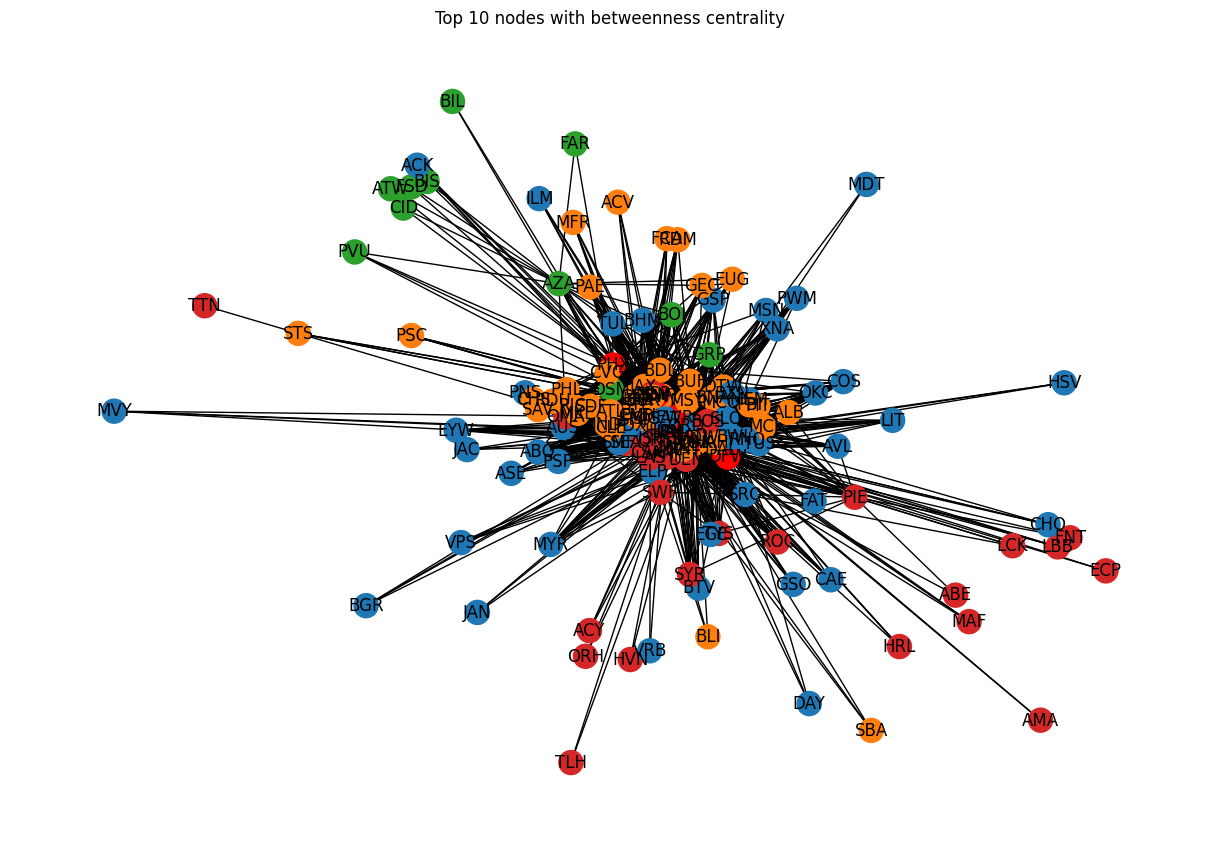

In [47]:
betweenness_cent = nx.betweenness_centrality(G)
b_list = betweenness_cent.items()

top_10_betweenness = sorted(b_list, key=lambda x: x[1], reverse=True)[:10]

print("Airports with highest betweenness centrality : What community they belong to")

for node, centrality in top_10_betweenness:
    community_id = partition[node]
    print(f"{node} with betweenness centrality {centrality} : {community_id}")


top_10_nodes = {node for node, _ in top_10_betweenness}
color_map = []
for node in G.nodes():
    if node in top_10_nodes:
        color_map.append('red')  
    else:
        community_color = partition[node]  # Get the community ID
        color_map.append(plt.cm.tab10(community_color % 10)) 


plt.figure(figsize=(12, 8))
nx.draw(G, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("Top 10 nodes with betweenness centrality")
plt.show()


This section then tries to simulate which airports would be disconnected to the ntework if we were to remove top 5 nodes of betweenness centrality, to compare how the list differs from the degree centrality disconnected airports.

['PHX', 'TPA', 'HPN', 'LGA', 'JFK', 'EWR']
disconnected node added
disconnected node added
disconnected node added
disconnected node added
disconnected node added
disconnected node added
disconnected node added
Disconnected nodes: ['ILM', 'JAC', 'TTN', 'ACK', 'MVY', 'BGR', 'CHO']


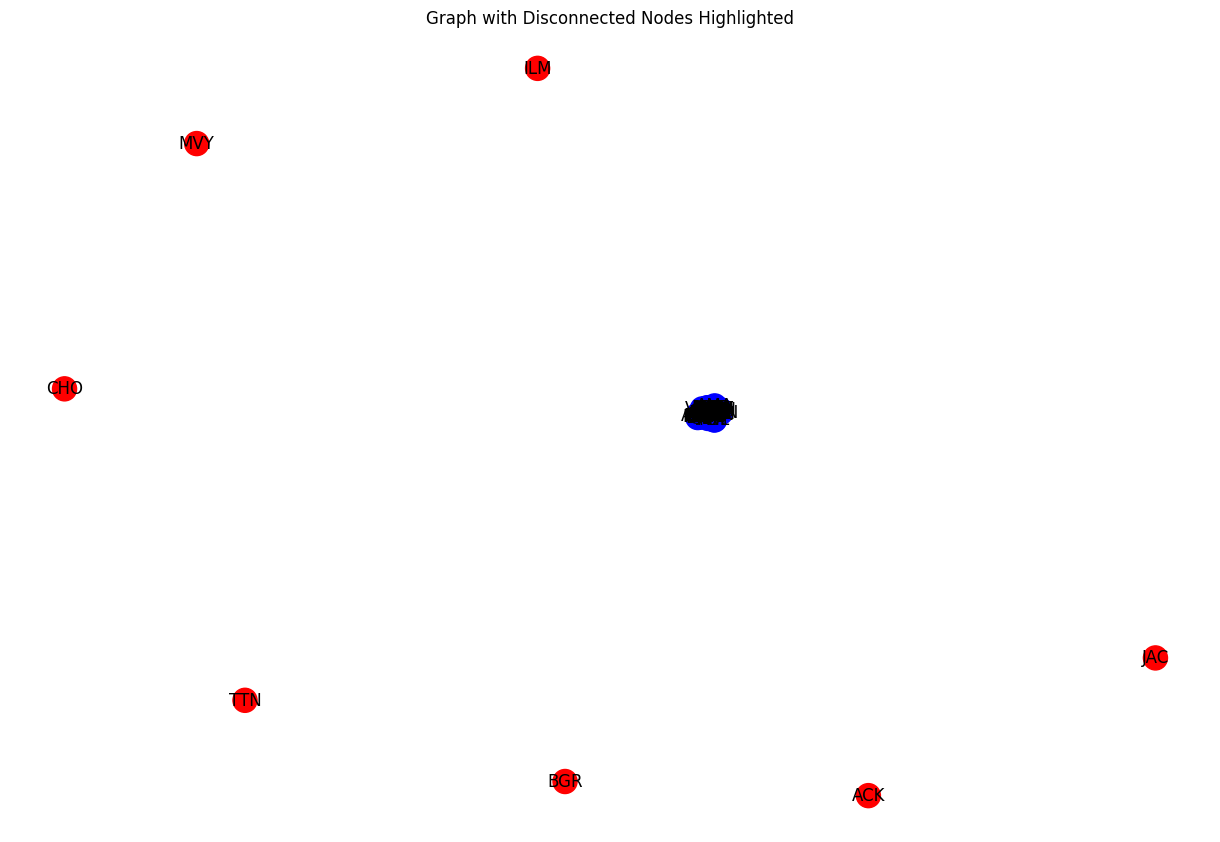

In [58]:
G_removed_2 = G.copy()

nodes_to_remove = []

for node, _ in top_10_betweenness:
    if(len(nodes_to_remove) > 5):
        break
    else:
        nodes_to_remove.append(node)

#G_removed_1.remove_node(top_10_betweenness[5][0])
G_removed_2.remove_nodes_from(nodes_to_remove)
#print(top_10_betweenness[5][0])
print(nodes_to_remove)

disconnected_nodes = []
for comp in list(nx.connected_components(G_removed_2)):
    if len(comp) == 1:  # Single-node components are disconnected
        disconnected_nodes.append(list(comp)[0])
        print("disconnected node added")

print(f"Disconnected nodes: {disconnected_nodes}")

color_map = []
for node in G_removed_2.nodes():
    if node in disconnected_nodes:
        color_map.append('red') 
    else:
        color_map.append('blue')  

plt.figure(figsize=(12, 8))
nx.draw(G_removed_2, node_color=color_map, with_labels=True, cmap=plt.cm.tab10)
plt.title("Graph with Disconnected Nodes Highlighted")
plt.show()

Since the lists are practically the same, I join the two lists of disconnected airports and use that as a base for the second part of the project.
I try and suggest new edges according what community each of these airports belong to and if that optimizes the network in any way.

Suggested connections for separated airports:
Connect ILM to EWR
Connect ILM to HPN
Connect ILM to JFK
Connect JAC to EWR
Connect JAC to HPN
Connect JAC to JFK
Connect ACK to EWR
Connect ACK to HPN
Connect ACK to JFK
Connect MVY to EWR
Connect MVY to HPN
Connect MVY to JFK
Connect BGR to EWR
Connect BGR to HPN
Connect BGR to JFK
Connect CHO to EWR
Connect CHO to HPN
Connect CHO to JFK
Connect TTN to TPA
Connect TTN to FLL
Connect TTN to MIA
Average shortest path length after adding edges: 1771.55
Modularity after adding edges: 0.12


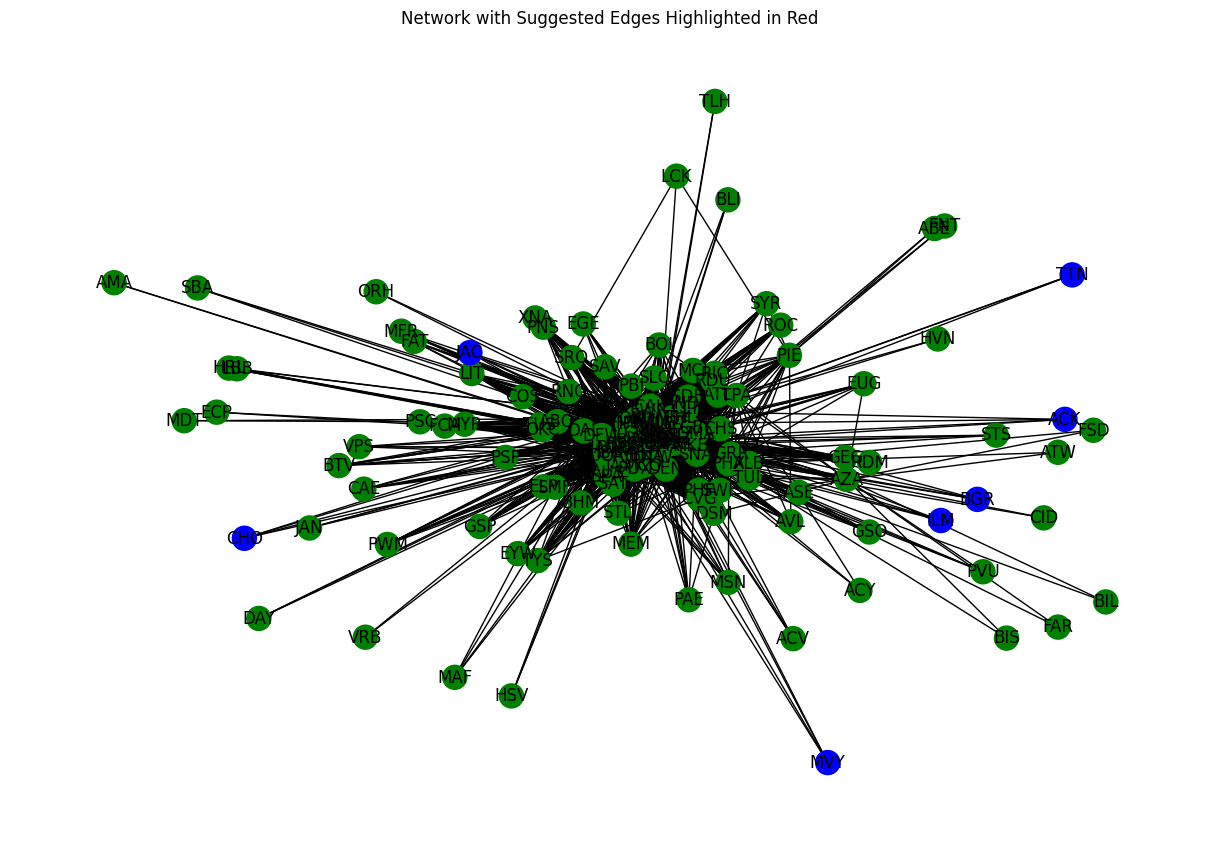

In [ ]:
airports_separated = ['ILM', 'JAC', 'ACK', 'MVY', 'BGR', 'CHO', 'TTN']

suggestions = []
for airport in airports_separated:
    # Get the community of the current airport
    community_id = partition[airport]
    community_airports = communities[community_id]

    # Calculate shortest path lengths within the community
    shortest_paths = {
        target: nx.shortest_path_length(G, source=airport, target=target, weight='weight')
        for target in community_airports
        if target != airport and G.has_node(target)
    }

    # Get the 3 nearest airports
    nearest_airports = sorted(shortest_paths.items(), key=lambda x: x[1])[:3]

    # Suggest edges to connect to these airports
    for target, _ in nearest_airports:
        suggestions.append((airport, target))

print("Suggested connections for separated airports:")
for suggestion in suggestions:
    print(f"Connect {suggestion[0]} to {suggestion[1]}")

# Add suggested edges to the graph and evaluate
G_new = G.copy()
G_new.add_edges_from(suggestions)


avg_shortest_path = nx.average_shortest_path_length(G_new, weight='weight')
print(f"Average shortest path length after adding edges: {avg_shortest_path:.2f}")


# Modularity
modularity_score = modularity(G_new, [set(nodes) for nodes in communities.values()])
print(f"Modularity after adding edges: {modularity_score:.2f}")

# Visualize the graph with suggested edges
edge_colors = ['red' if edge in suggestions else 'black' for edge in G_new.edges()]
node_colors = ['blue' if node in airports_separated else 'green' for node in G_new.nodes()]

plt.figure(figsize=(12, 8))
nx.draw(
    G_new,
    node_color=node_colors,
    edge_color=edge_colors,
    with_labels=True,
    cmap=plt.cm.tab10
)
plt.title("Network with Suggested Edges Highlighted in Red")
plt.show()

Here, I get the "medium" connected nodes from each community and try suggest new edges between disconnecetd airports and airports from other communities that are in the 20%-80% threshold to see whether anything in the network changes.

In [60]:
degree_centrality = nx.degree_centrality(G)
medium_nodes = {}

for community_id, nodes in communities.items():
    for community_id, nodes in communities.items():
        sorted_nodes = sorted(nodes, key=lambda x: degree_centrality[x])
        n = len(sorted_nodes)
        ind_20 = int(0.20 * n)
        ind_80 = int(0.80 * n)
        medium_nodes[community_id] = sorted_nodes[ind_20 : ind_80]

print("Medium-connected nodes in each community:")
for community_id, nodes in medium_nodes.items():
    print(f"Community {community_id}: {nodes}")


Medium-connected nodes in each community:
Community 0: ['VPS', 'FAT', 'EGE', 'GSO', 'CAE', 'ASE', 'MSN', 'BTV', 'PWM', 'XNA', 'GSP', 'LIT', 'PSP', 'EYW', 'AVL', 'PNS', 'COS', 'MYR', 'SRQ', 'TUL', 'OKC', 'BHM', 'TUS', 'ELP', 'RNO', 'BZN', 'SMF', 'ABQ', 'MEM', 'AUS', 'SAT', 'SLC', 'PDX']
Community 1: ['GEG', 'EUG', 'ALB', 'BDL', 'PBI', 'PHL', 'SAV', 'SDF', 'MKE', 'RIC', 'DTW', 'RSW', 'RDU', 'BUF', 'CHS', 'IND', 'PIT', 'JAX', 'MCI', 'MSY', 'STL', 'CVG', 'BNA', 'CLT', 'MCO', 'ATL', 'CMH', 'CLE', 'PVD']
Community 2: ['BIL', 'BIS', 'CID', 'FAR', 'PVU', 'BOI', 'AZA']
Community 3: ['ORH', 'TLH', 'ACY', 'LCK', 'HRL', 'LBB', 'MAF', 'SYR', 'ROC', 'SWF', 'TYS', 'PIE', 'PHF', 'OMA', 'SAN', 'ORF', 'SEA', 'MSP', 'DEN', 'LAS']


In [61]:
# Suggest connections
suggestions = []
for airport in airports_separated:
    airport_community = partition[airport]

    # Find medium-connected nodes in other communities
    for community_id, nodes in medium_nodes.items():
        if community_id != airport_community:
            for target in nodes:
                if not G.has_edge(airport, target) and not G.has_edge(target, airport):
                    suggestions.append((airport, target))
                    break
            break  

print("Suggested connections for optimization:")
for suggestion in suggestions:
    print(f"Connect {suggestion[0]} to {suggestion[1]}")

G_new = G.copy()
G_new.add_edges_from(suggestions)

avg_shortest_path = nx.average_shortest_path_length(G_new, weight='weight')
print(f"Average shortest path length after adding edges: {avg_shortest_path:.2f}")

diameter = nx.diameter(G_new, weight='weight')
print(f"Diameter of the network after adding edges: {diameter}")



Suggested connections for optimization:
Connect ILM to GEG
Connect JAC to GEG
Connect ACK to GEG
Connect MVY to GEG
Connect BGR to GEG
Connect CHO to GEG
Connect TTN to VPS
Average shortest path length after adding edges: 1568.28
Diameter of the network after adding edges: 4667


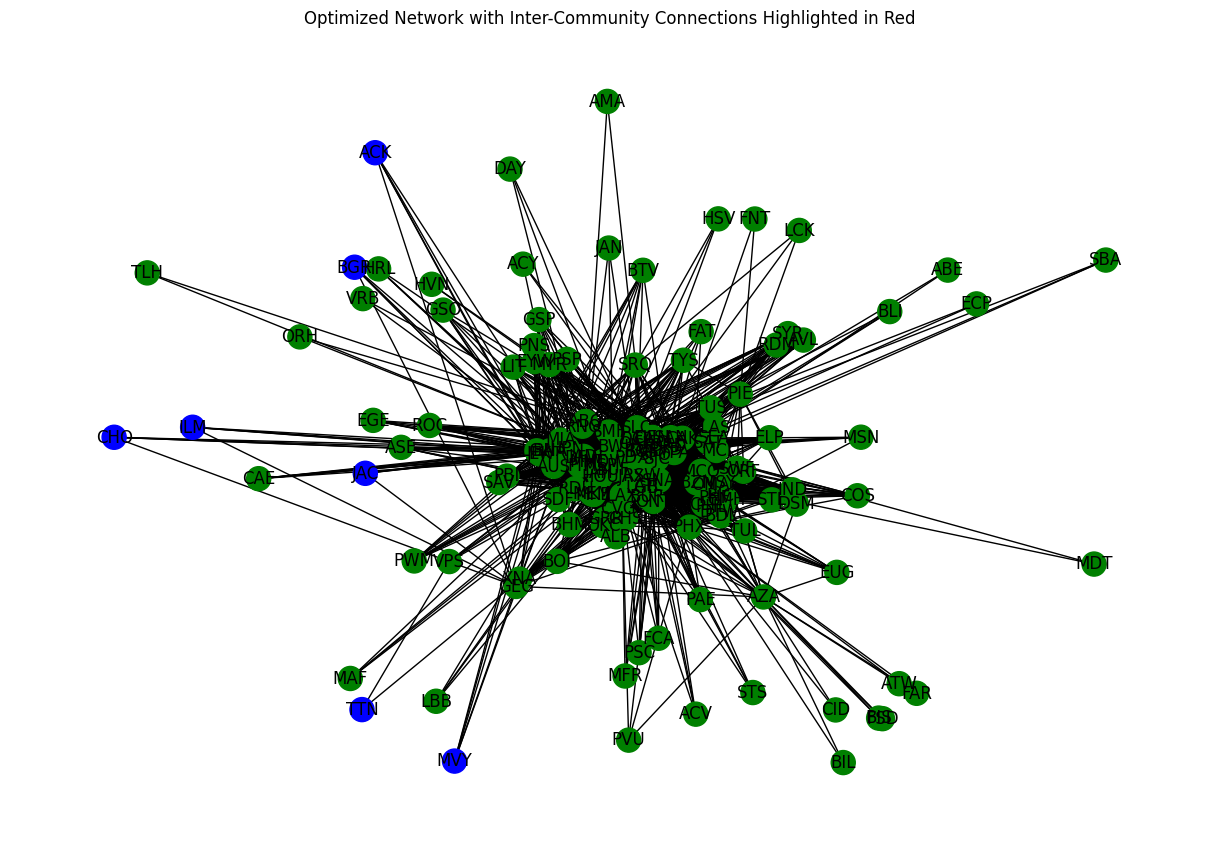

In [62]:
# Visualize the graph with added edges
edge_colors = ['red' if edge in suggestions else 'black' for edge in G_new.edges()]
node_colors = ['blue' if node in airports_separated else 'green' for node in G_new.nodes()]

plt.figure(figsize=(12, 8))
nx.draw(
    G_new,
    node_color=node_colors,
    edge_color=edge_colors,
    with_labels=True,
    cmap=plt.cm.tab10
)
plt.title("Optimized Network with Inter-Community Connections Highlighted in Red")
plt.show()